<a href="https://colab.research.google.com/github/oaarnikoivu/dissertation/blob/master/BERT_TextCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Imports

In [0]:
import torch
import random
import transformers
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from torchtext import data
from transformers import BertModel, BertTokenizer

# Arguments

In [0]:
args = {
    "bert_model": "bert-base-uncased",
    "seed": 1234,
    "batch_size": 64,
    "num_filters": 100,
    "filter_sizes": [3,4,5],
    "output_dim": 11,
    "dropout": 0.5,
    "epochs": 10
}

# Bert Tokenizer

In [6]:
tokenizer = BertTokenizer.from_pretrained(args['bert_model'])

In [7]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


In [8]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [9]:
max_input_length = tokenizer.max_model_input_sizes[args['bert_model']]

print(max_input_length)

512


# Tokenize text

In [0]:
def tokenize_and_cut(tweet):
  tokens = tokenizer.tokenize(tweet)
  tokens = tokens[:max_input_length-2]
  return tokens

# Load & Generate Data

In [0]:
file_path = '/content/drive/My Drive'

DATA_PATH = Path(file_path + '/datasets/SemEval')

random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
torch.backends.cudnn.deterministic = True

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(sequential = False,
                        use_vocab = False,
                        pad_token= None,
                        unk_token = None, 
                        dtype = torch.float)

dataFields = {"Tweet": ("Tweet", TEXT),
              'anger': ("anger", LABEL),
              'anticipation': ("anticipation", LABEL),
              'disgust': ("disgust", LABEL),
              'fear': ("fear", LABEL),
              'joy': ("joy", LABEL),
              'love': ("love", LABEL),
              'optimism': ("optimism", LABEL),
              'pessimism': ("pessimism", LABEL),
              'sadness': ("sadness", LABEL),
              'surprise': ("surprise", LABEL),
              'trust': ("trust", LABEL)}

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = DATA_PATH,
    train = 'train.csv',
    validation = 'val.csv',
    test = 'test.csv',
    format = 'csv',
    fields = dataFields
)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.Tweet),
    sort_within_batch = True,
    batch_size = args['batch_size'],
    device = device
)

# Setup Batch Wrapper

In [0]:
LABEL_COLS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
              'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

iaux = 0

for batch in valid_iterator:
  iaux += 1
  aux = batch
  aux2 = torch.stack([getattr(batch, label) for label in LABEL_COLS])
  if aux == 20: break;

# Build the Model

Load the pretrained bert model from the HuggingFace transformers library.

https://github.com/huggingface/transformers


In [0]:
bert = BertModel.from_pretrained(args['bert_model'])

We use the pre-trained bert transformer model to produce embeddings which are then fed into the TextCNN architecture proposed by Yoon Kim at: https://arxiv.org/abs/1408.5882

In [0]:
class BertCNN(nn.Module):
  def __init__(self, bert, n_filters, filter_sizes, output_dim, dropout):
    super().__init__()

    self.bert = bert 

    embedding_dim = 768

    self.convs = nn.ModuleList([
                                nn.Conv2d(in_channels = 1,
                                          out_channels = n_filters,
                                          kernel_size = (fs, embedding_dim)) 
                                for fs in filter_sizes])
    
    self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

    self.dropout = nn.Dropout(dropout)
  
  def forward(self, text):
    with torch.no_grad():
      embedded = self.bert(text)[0]
    
    embedded = embedded.unsqueeze(1)
    
    conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    
    cat = self.dropout(torch.cat(pooled, dim = 1))
    
    return self.fc(cat)

In [28]:
model = BertCNN(bert=bert, 
                n_filters=args['num_filters'], 
                filter_sizes=args['filter_sizes'], 
                output_dim=args['output_dim'], 
                dropout=args['dropout'])

model

BertCNN(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

Next we freeze the parameters which are a part of the Bert Transformers model. 

In [0]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [30]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

convs.0.weight
convs.0.bias
convs.1.weight
convs.1.bias
convs.2.weight
convs.2.bias
fc.weight
fc.bias


# Train the Model

In [0]:
import torch.optim as optim
import pandas as pd

In [0]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We evaluate using the Jaccard Index and the macro and micro F1's as there are more suitable for multi-label text classification.

In [0]:
from sklearn.metrics import roc_auc_score, f1_score, jaccard_similarity_score

In [0]:
def metricize(preds, y):
  f1_macro = f1_score(y, preds.round(), average='macro')
  f1_micro = f1_score(y, preds.round(), average='micro')
  #acc = roc_auc_score(y, preds)
  acc = jaccard_similarity_score(y, preds.round())

  return {
      'f1_macro': f1_macro,
      'f1_micro': f1_micro,
      'acc': acc
  }

In [0]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0

  model.train()

  preds_list = []
  labels_list = []

  for i, batch in enumerate(iterator):
    
    optimizer.zero_grad()
    
    predictions = model(batch.Tweet).squeeze(1)

    batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
    batch_labels = torch.transpose(batch_labels, 0, 1)

    loss = criterion(predictions, batch_labels)

    loss.backward()

    optimizer.step()

    preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
    labels_list += [batch_labels.cpu().numpy()]

    epoch_loss += loss.item()
  
  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
def evaluate(model, iterator, criterion):

  epoch_loss = 0

  model.eval()

  preds_list = []
  labels_list = []

  with torch.no_grad():
    
    for batch in iterator:

      predictions = model(batch.Tweet).squeeze(1)

      batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
      batch_labels = torch.transpose(batch_labels, 0, 1)

      loss = criterion(predictions, batch_labels)

      epoch_loss += loss.item()

      preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
      labels_list += [batch_labels.cpu().numpy()]

  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We train the model for 10 epochs and record the training and validation loss.


In [43]:
best_valid_loss = float('inf')

train_history = []
valid_history = []

for epoch in range(args['epochs']):

    start_time = time.time()
    
    train_loss, train_metrics = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_metrics = evaluate(model, valid_iterator, criterion)

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bert-cnn-model.pt')

    train_acc = train_metrics['acc']
    train_micro = train_metrics['f1_micro']
    train_macro = train_metrics['f1_macro']

    valid_acc = valid_metrics['acc']
    valid_micro = valid_metrics['f1_micro']
    valid_macro = valid_metrics['f1_macro']
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train F1 Micro: {train_micro*100:.2f}% | Train F1 Macro: {train_macro*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%  | Val. F1 Micro: {valid_micro*100:.2f}%  | Val. F1 Macro: {valid_macro*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 0.427 | Train Acc: 29.60% | Train F1 Micro: 41.99% | Train F1 Macro: 24.98%
	 Val. Loss: 0.351 | Val. Acc: 43.48%  | Val. F1 Micro: 57.98%  | Val. F1 Macro: 36.38%
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.359 | Train Acc: 43.49% | Train F1 Micro: 57.12% | Train F1 Macro: 37.81%
	 Val. Loss: 0.339 | Val. Acc: 45.91%  | Val. F1 Micro: 59.64%  | Val. F1 Macro: 37.62%
Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.335 | Train Acc: 47.31% | Train F1 Micro: 60.57% | Train F1 Macro: 42.07%
	 Val. Loss: 0.332 | Val. Acc: 48.08%  | Val. F1 Micro: 61.66%  | Val. F1 Macro: 41.30%
Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 0.322 | Train Acc: 49.49% | Train F1 Micro: 62.71% | Train F1 Macro: 45.07%
	 Val. Loss: 0.326 | Val. Acc: 51.25%  | Val. F1 Micro: 64.69%  | Val. F1 Macro: 45.66%
Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 0.311 | Train Acc: 51.55% | Train F1 Micro: 64.40% | Train F1 Macro: 46.98%
	 Val. Loss: 0.320 | Val. Acc: 52.55%  | Val. F1

# Visualize the training and validation loss

In [0]:
import matplotlib.pyplot as plt

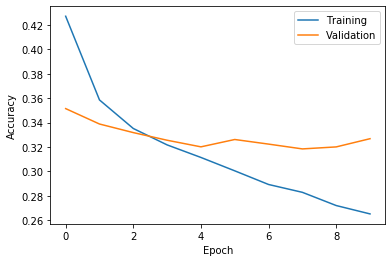

In [45]:
plt.plot(train_history)
plt.plot(valid_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

# Assess model performance on testing data

In [46]:
model.load_state_dict(torch.load('bert-cnn-model.pt'))

test_loss, test_metrics = evaluate(model, test_iterator, criterion)

test_acc = test_metrics['acc']
test_micro = test_metrics['f1_micro']
test_macro = test_metrics['f1_macro']

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1 Micro: {test_micro*100:.2f}% | Test F1 Macro: {test_macro*100:.2f}%')

Test Loss: 0.316 | Test Acc: 53.31% | Test F1 Micro: 65.66% | Test F1 Macro: 46.69%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


# Inference

In [0]:
def predict_emotion(model, tokenizer, tweet):
  preds = []
  model.eval()
  tokens = tokenizer.tokenize(tweet)
  tokens = tokens[:max_input_length-2]
  indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(0)
  predictions = model(tensor)
  preds.append(torch.sigmoid(predictions).detach().cpu().numpy())
  return preds

In [52]:
preds = predict_emotion(model, tokenizer, "Good music, I love that shit.")

vals = []
for p in preds[0]:
  for val in p:
    vals.append(val)

for i, label in enumerate(LABEL_COLS):
  print(f"{label.upper()}: {vals[i]}")

ANGER: 0.049273427575826645
ANTICIPATION: 0.1092911958694458
DISGUST: 0.06299421936273575
FEAR: 0.007006073836237192
JOY: 0.9334051012992859
LOVE: 0.5966441631317139
OPTIMISM: 0.5715864896774292
PESSIMISM: 0.011290102265775204
SADNESS: 0.028145330026745796
SURPRISE: 0.025997860357165337
TRUST: 0.2837657332420349
